In [12]:
import os
import pandas
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten,Dense,Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [13]:
train_dir = "/kaggle/input/kermanys-cxr-images-datasets/chest_xray/train"
test_dir = "/kaggle/input/kermanys-cxr-images-datasets/chest_xray/test"
# ============================
# Data Augmentation for Training + Validation Split
# ============================
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2   # <-- 20% for validation
)
# Training generator (80%)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode="binary",
    subset="training",   # <-- important
    shuffle=True
)
# Validation generator (20%)
val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size= 128,
    class_mode="binary",
    subset="validation",  # <-- important
    shuffle=True
)
# ============================
# Test Data (no augmentation, only rescaling)
# ============================
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=128,
    class_mode="binary",
    shuffle=False
)

Found 4187 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf

In [15]:
# ============================
# Class Weights
# ============================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))

In [16]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Flatten, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import AdamW

In [33]:
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow as tf
# ============================
# Learning rate scheduler
# ============================
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:  # every 3 epochs
        return lr * 0.5               # reduce by factor of 2
    return lr

lr_callback = LearningRateScheduler(scheduler, verbose=1)
# ============================
# DenseNet121 Pretrained Model
# ============================
class_labels = ["NORMAL", "PNEUMONIA"]
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

# Custom classification head
DenseNet_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile model
DenseNet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Model summary
DenseNet_model.summary()
# ============================
# Train Model with LR schedule
# ============================
history_DenseNet = DenseNet_model.fit(train_generator,epochs = 30,validation_data=val_generator,class_weight=class_weights,callbacks=[lr_callback])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_21     │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,304,257 (27.86 MB)

 Trainable params: 264,705 (1.01 MB)

 Non-trainable params: 7,039,552 (26.85 MB)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 144s 4s/step - accuracy: 0.8050 - loss: 0.3875 - val_accuracy: 0.9120 - val_loss: 0.2522 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9427 - loss: 0.1319 - val_accuracy: 0.9550 - val_loss: 0.1616 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9558 - loss: 0.0987 - val_accuracy: 0.9483 - val_loss: 0.1553 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9560 - loss: 0.1192 - val_accuracy: 0.9579 - val_loss: 0.1275 - learning_rate: 5.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487

In [35]:
# ============================
# VGG16 Pretrained Model
# ============================
# ============================
# Learning rate scheduler
# ============================
def scheduler(epoch, lr):
    if epoch > 0 and epoch % 3 == 0:  # every 3 epochs
        return lr * 0.5               # reduce by factor of 2
    return lr

class_labels = ["NORMAL", "PNEUMONIA"]
# Load VGG16 without top classification layer
VGG16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze base layers
for layer in VGG16_base.layers:
    layer.trainable = False
# Custom classification head
VGG16_model = Sequential([
    VGG16_base,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])
# Compile model
VGG16_model.compile(
    optimizer= "adam",
    loss='binary_crossentropy',
    metrics=['accuracy']
)
# ============================
# Class Weights
# ============================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights = dict(enumerate(class_weights))
# Model summary
VGG16_model.summary()
# ============================
# Train Model
# ============================
history_vgg16 = VGG16_model.fit(train_generator,epochs = 30,validation_data=val_generator,class_weight=class_weights,callbacks=[lr_callback])

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_23     │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,321 (56.64 MB)

 Trainable params: 132,609 (518.00 KB)

 Non-trainable params: 14,715,712 (56.14 MB)


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.7825 - loss: 0.4325 - val_accuracy: 0.7426 - val_loss: 0.4751 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.9264 - loss: 0.1790 - val_accuracy: 0.7493 - val_loss: 0.4550 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9330 - loss: 0.1626 - val_accuracy: 0.7531 - val_loss: 0.4229 - learning_rate: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.9408 - loss: 0.1416 - val_accuracy: 0.7856 - val_loss: 0.3949 - learning_rate: 5.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005000000237487

In [73]:
# Predict the probabilities & Convert them to binary labels
y_pred_densenet = DenseNet_model.predict(test_generator)
y_class_densenet = (y_pred_densenet > 0.5).astype(int)
y_pred_vgg = VGG16_model.predict(test_generator)
y_class_vgg = (y_pred_vgg > 0.5).astype(int)

# ========================================
# Compute metrics for each model
# ========================================
def get_metrics(y_true, y_pred_probs, y_pred_class):
    accuracy = accuracy_score(y_true, y_pred_class)
    precision = precision_score(y_true, y_pred_class)
    recall = recall_score(y_true, y_pred_class)
    f1 = f1_score(y_true, y_pred_class)
    auc = roc_auc_score(y_true, y_pred_probs)
    return [accuracy,precision,recall, f1, auc]

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step


In [74]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

In [75]:
# True labels from generator
y_true = test_generator.classes   

In [82]:
metrics_vgg = get_metrics(y_true, y_pred_vgg, y_class_vgg)
metrics_densenet = get_metrics(y_true, y_pred_densenet, y_class_densenet)
print("VGG16 Metrics:", metrics_vgg)
print("DenseNet121 Metrics:", metrics_densenet)

VGG16 Metrics: [0.9375, 0.9420654911838791, 0.958974358974359, 0.9504447268106735, 0.9806596537365767]
DenseNet121 Metrics: [0.9455128205128205, 0.9494949494949495, 0.9641025641025641, 0.9567430025445293, 0.9861165899627439]


In [83]:
# ========================================
# Compute weights using tanh
# ========================================
def compute_weight(metrics, alpha=1.5):
    # Apply tanh to each metric, then average
    weights = [np.tanh(alpha * m) for m in metrics]
    return np.mean(weights)

w_vgg = compute_weight(metrics_vgg)
w_densenet = compute_weight(metrics_densenet)

In [84]:
# Normalize weights to sum = 1
w_sum = w_vgg + w_densenet 
w_vgg /= w_sum
w_densenet /= w_sum

print("Normalized Weights:")
print("VGG16:", w_vgg, " DenseNet121:", w_densenet)

# ========================================
# STEP 4: Weighted Ensemble Prediction
# ========================================
# Weighted average of probability scores
y_pred_ensemble = (w_vgg * y_pred_vgg +w_densenet * y_pred_densenet)
# Final binary predictions
y_class_ensemble = (y_pred_ensemble > 0.5).astype(int)

Normalized Weights:
VGG16: 0.49944571849392727  DenseNet121: 0.5005542815060727


In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# ========================================
# Evaluate Ensemble
# ========================================
accuracy = accuracy_score(y_true, y_class_ensemble)
precision = precision_score(y_true, y_class_ensemble)
recall = recall_score(y_true, y_class_ensemble)
f1 = f1_score(y_true, y_class_ensemble)
auc = roc_auc_score(y_true, y_pred_ensemble)

print("\nEnsemble Performance:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC:", auc)



Ensemble Performance:
Accuracy: 0.9519230769230769
Precision: 0.9615384615384616
Recall: 0.9615384615384616
F1 Score: 0.9615384615384616
AUC: 0.9858316896778435


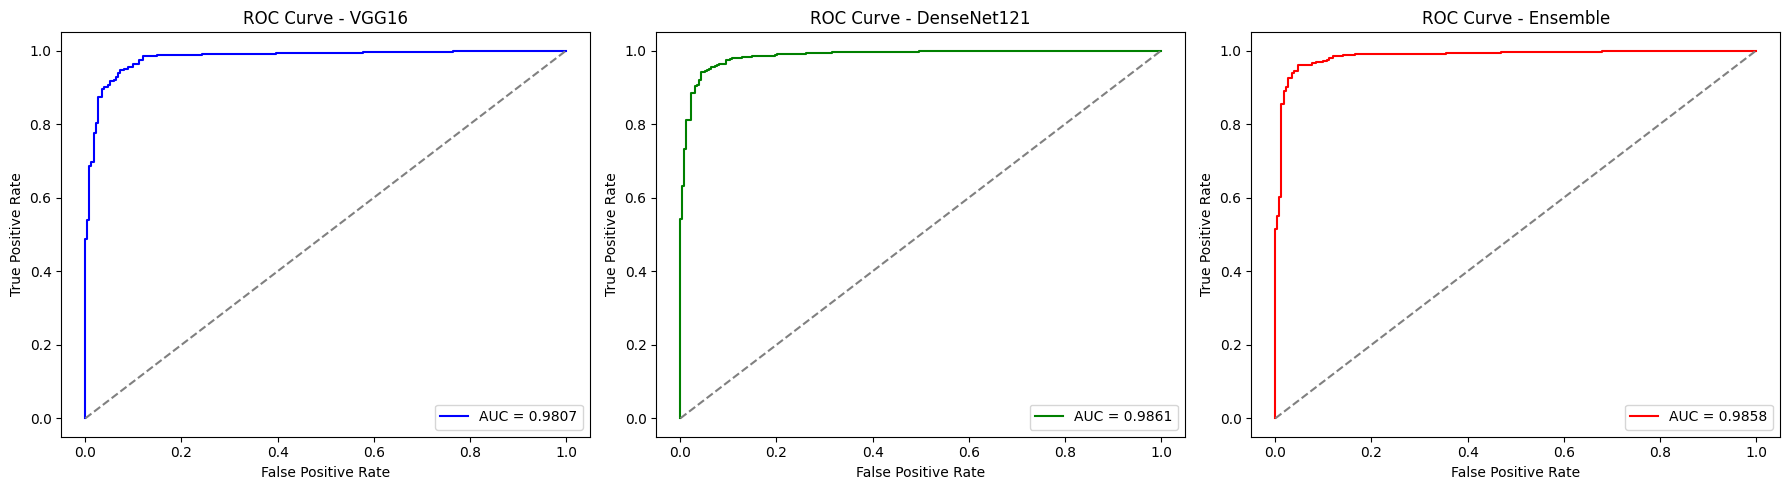

In [86]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# ============================
# Get predictions for each model
# ============================
y_true = test_generator.classes  # ground truth labels

# VGG16 predictions
fpr_vgg, tpr_vgg, _ = roc_curve(y_true, y_pred_vgg)
roc_auc_vgg = auc(fpr_vgg, tpr_vgg)

# DenseNet predictions
fpr_dense, tpr_dense, _ = roc_curve(y_true, y_pred_densenet)
roc_auc_dense = auc(fpr_dense, tpr_dense)

# Ensemble predictions
fpr_ens, tpr_ens, _ = roc_curve(y_true, y_pred_ensemble)
roc_auc_ens = auc(fpr_ens, tpr_ens)

# ============================
# Plot ROC curves with subplots
# ============================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# --- VGG16 ---
axes[0].plot(fpr_vgg, tpr_vgg, color="blue", label=f"AUC = {roc_auc_vgg:.4f}")
axes[0].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[0].set_title("ROC Curve - VGG16")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].legend()

# --- DenseNet121 ---
axes[1].plot(fpr_dense, tpr_dense, color="green", label=f"AUC = {roc_auc_dense:.4f}")
axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[1].set_title("ROC Curve - DenseNet121")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].legend()

# --- Ensemble ---
axes[2].plot(fpr_ens, tpr_ens, color="red", label=f"AUC = {roc_auc_ens:.4f}")
axes[2].plot([0, 1], [0, 1], linestyle="--", color="gray")
axes[2].set_title("ROC Curve - Ensemble")
axes[2].set_xlabel("False Positive Rate")
axes[2].set_ylabel("True Positive Rate")
axes[2].legend()

plt.tight_layout()
plt.show()

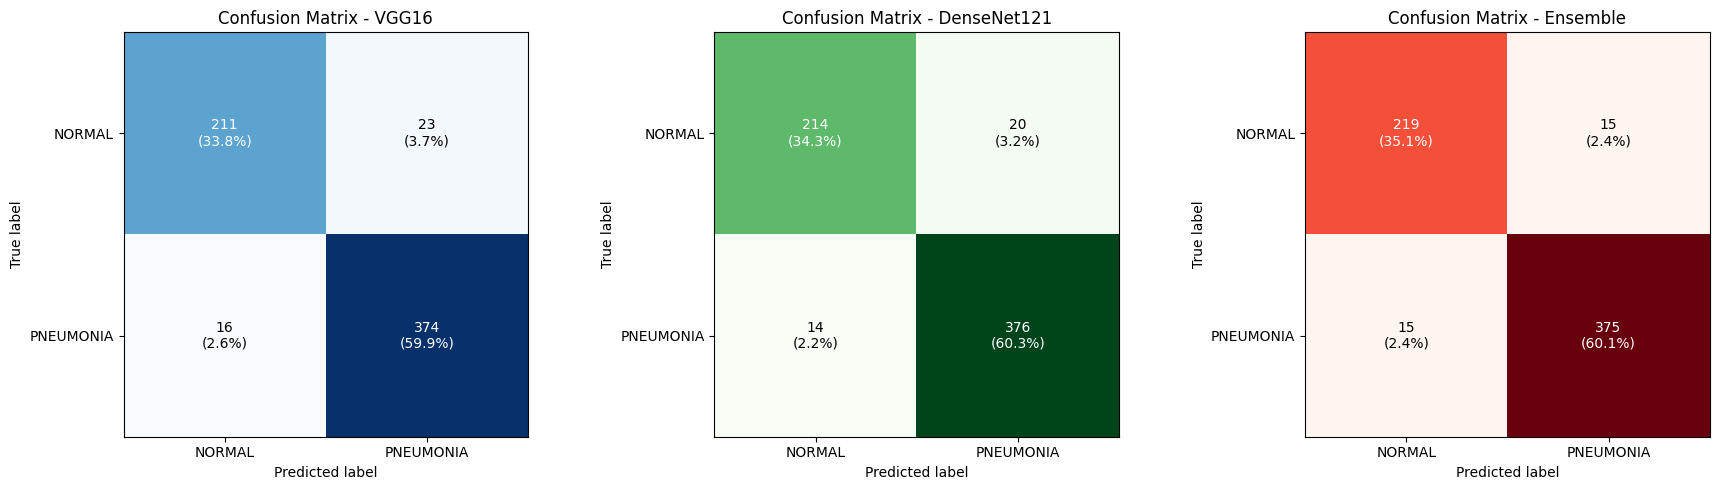

In [88]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# ============================
# True labels
# ============================
y_true = test_generator.classes
class_names = ["NORMAL", "PNEUMONIA"]


# ============================
# Confusion Matrices
# ============================
cm_vgg = confusion_matrix(y_true, y_class_vgg)
cm_dense = confusion_matrix(y_true, y_class_densenet)
cm_ens = confusion_matrix(y_true, y_class_ensemble)

cms = [cm_vgg, cm_dense, cm_ens]
titles = ["Confusion Matrix - VGG16", "Confusion Matrix - DenseNet121", "Confusion Matrix - Ensemble"]
cmaps = ["Blues", "Greens", "Reds"]

# ============================
# Plot Confusion Matrices with counts + percentages
# ============================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, cm, title, cmap in zip(axes, cms, titles, cmaps):
    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")

    # Annotate with count and percentage
    total = np.sum(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            count = cm[i, j]
            percent = (count / total) * 100
            ax.text(j, i, f"{count}\n({percent:.1f}%)",
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2 else "black")

plt.tight_layout()
plt.show()